In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import os
import yaml
import pandas as pd
import h5py

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from scipy import interpolate

In [3]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import mathlib

In [4]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/'

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [26]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo/'
dir_disp = dir_project + info_basic['rdir_disp_model']
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [8]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [9]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

key_subworks_all = info_basic['key_subworks']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 

stations_this = {}
lat_stations_this = {}
lon_stations_this = {}
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_this[key] = stations_this
    lat_stations_this[key] = lat.astype(float)
    lon_stations_this[key] = lon.astype(float)

stations_probes = {}
lat_probes = {}
lon_probes = {}
lon_centroid_probes = []
lat_centroid_probes = []
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)
    lon_centroid_probes.append(np.mean(lon_this.astype(float)))
    lat_centroid_probes.append(np.mean(lat_this.astype(float)))

stations_targets = {}
lat_targets = {}
lon_targets = {}
lon_centroid_targets = []
lat_centroid_targets = []
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    lon_centroid_targets.append(np.mean(lon_this.astype(float)))
    lat_centroid_targets.append(np.mean(lat_this.astype(float)))

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [11]:
f_list = [5,10,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in info_basic['key_subworks']:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [12]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lon_centroid_partition = []
lat_centroid_partition = []
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat.astype(float)
    lon_stations_partition[key] = lon.astype(float)
    lon_centroid_partition.append(np.mean(lon.astype(float)))
    lat_centroid_partition.append(np.mean(lat.astype(float)))

In [13]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

### Probes and Targets

In [14]:
def extract_probes(target):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stations_targets

    stas = stations_targets[target]
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [15]:
def find_nearest(lon_this,lat_this,lon_stations_all,lat_stations_all):
    lon_stations_all = np.array(lon_stations_all)
    lat_stations_all = np.array(lat_stations_all)
    lon_stations_all = lon_stations_all.reshape(-1,1)
    lat_stations_all = lat_stations_all.reshape(-1,1)
    dist = np.sqrt((lon_stations_all-lon_this)**2+(lat_stations_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    #print(lon_stations_all)
    #print(index)
    return index

In [16]:
key_subwork = '277--26-10'
key_probe = '24-10'
key_target = '26-10'
f_range = [10,16]

points = np.column_stack((lon_targets[key_target],lat_targets[key_target]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_target = list(points[hull.vertices,0])
lon_edge_target.append(points[hull.vertices,0][0])
lat_edge_target = list(points[hull.vertices,1])
lat_edge_target.append(points[hull.vertices,1][0])

points = np.column_stack((lon_probes[key_probe],lat_probes[key_probe]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_probe = list(points[hull.vertices,0])
lon_edge_probe.append(points[hull.vertices,0][0])
lat_edge_probe = list(points[hull.vertices,1])
lat_edge_probe.append(points[hull.vertices,1][0])

points = np.column_stack((lon_stations_partition[key_subwork],lat_stations_partition[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
disp_all = {}
for probe in probes_this:
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp_all[probe] = disp[index,:]
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])
# calculate relative error between all probes and reference probe
err = []
f_sample = np.linspace(f_range[0],f_range[1],200,endpoint=False)
f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
c_pick_ref = f(f_sample)
c_pick = {}
for probe in probes_this:
    c_pick[probe] = []
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp = disp[index,:]
    f_this = disp[:,0]
    c_this = disp[:,1]
    # 生成插值函数,可以外推
    #f = interpolate.interp1d(f_this,c_this,kind='cubic')
    f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
    c_pick[probe] = f(f_sample)

    max_disp = np.sum( np.maximum(np.array(c_pick_ref),np.array(c_pick[probe])) )
    abs_err = np.sum( np.abs(np.abs(np.array(c_pick_ref))-np.abs(np.array(c_pick[probe]))) )
    err.append(abs_err/max_disp) 

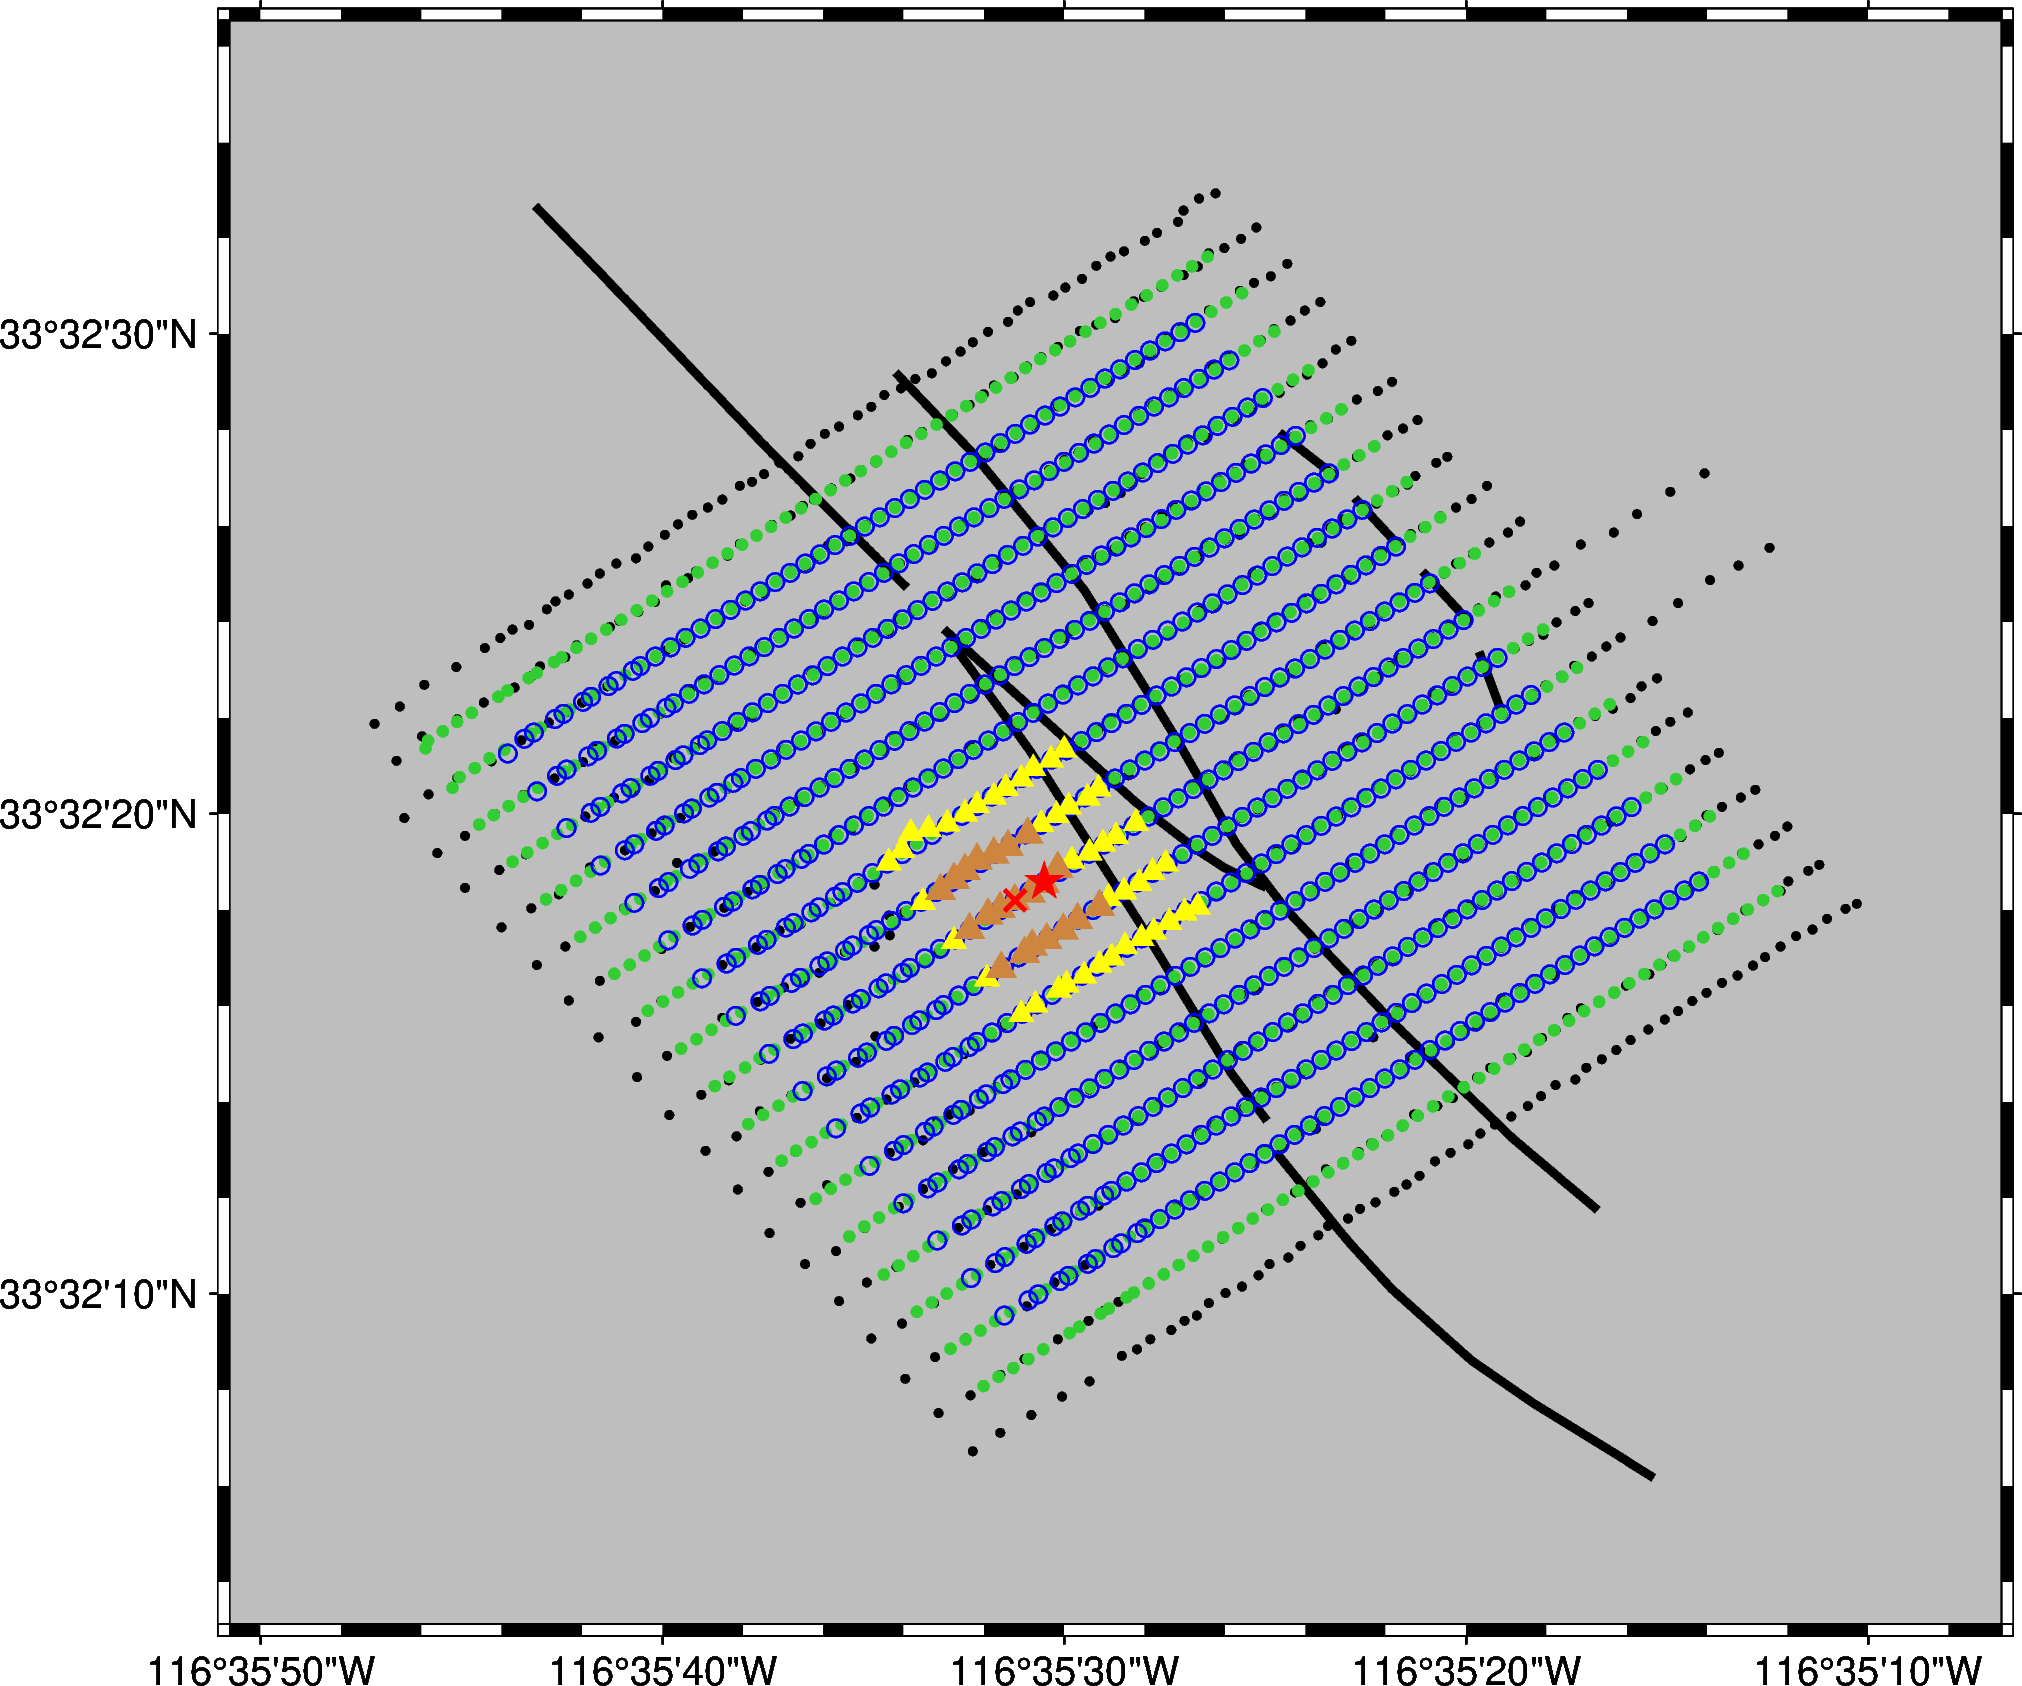

In [17]:
fig = pygmt.Figure()
flag_red = 0.001
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection="M15c", 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection="M15c", frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.08')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "2p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "2p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "2p,black,-")
# targets and probes
fig.plot(x=lon_centroid_probes, y=lat_centroid_probes, style='c0.1',fill='limegreen' , label='All Probes centroid')
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.15',pen='0.5p,blue', label='All targets centroid')
# sample target and probe
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='t0.25',fill = 'yellow', label='Arrays of sample target')
fig.plot(x=lon_probes[key_probe], y=lat_probes[key_probe], style='t0.3',fill = 'peru', label='Arrays of sample probe')
#fig.plot(x=lon_edge_target, y=lat_edge_target, pen='1p,yellow', label='target boundary')
#fig.plot(x=lon_edge_probe, y=lat_edge_probe, pen='1.5p,peru,-', label='probe boundary')
fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='a0.35',fill = 'red', label=' sample target centroid')
fig.plot(x=lon_centroid_probes[probes.index(key_probe)], y=lat_centroid_probes[probes.index(key_probe)], style='x0.25',fill = 'red', label=' sample probe centroid')
#fig.legend(position='jTR+o0.2c', box='+gwhite+p1p')
fig.show()
fig.savefig(dir_image+'partitionworkflow_targetprobe.eps')

### Error distribution

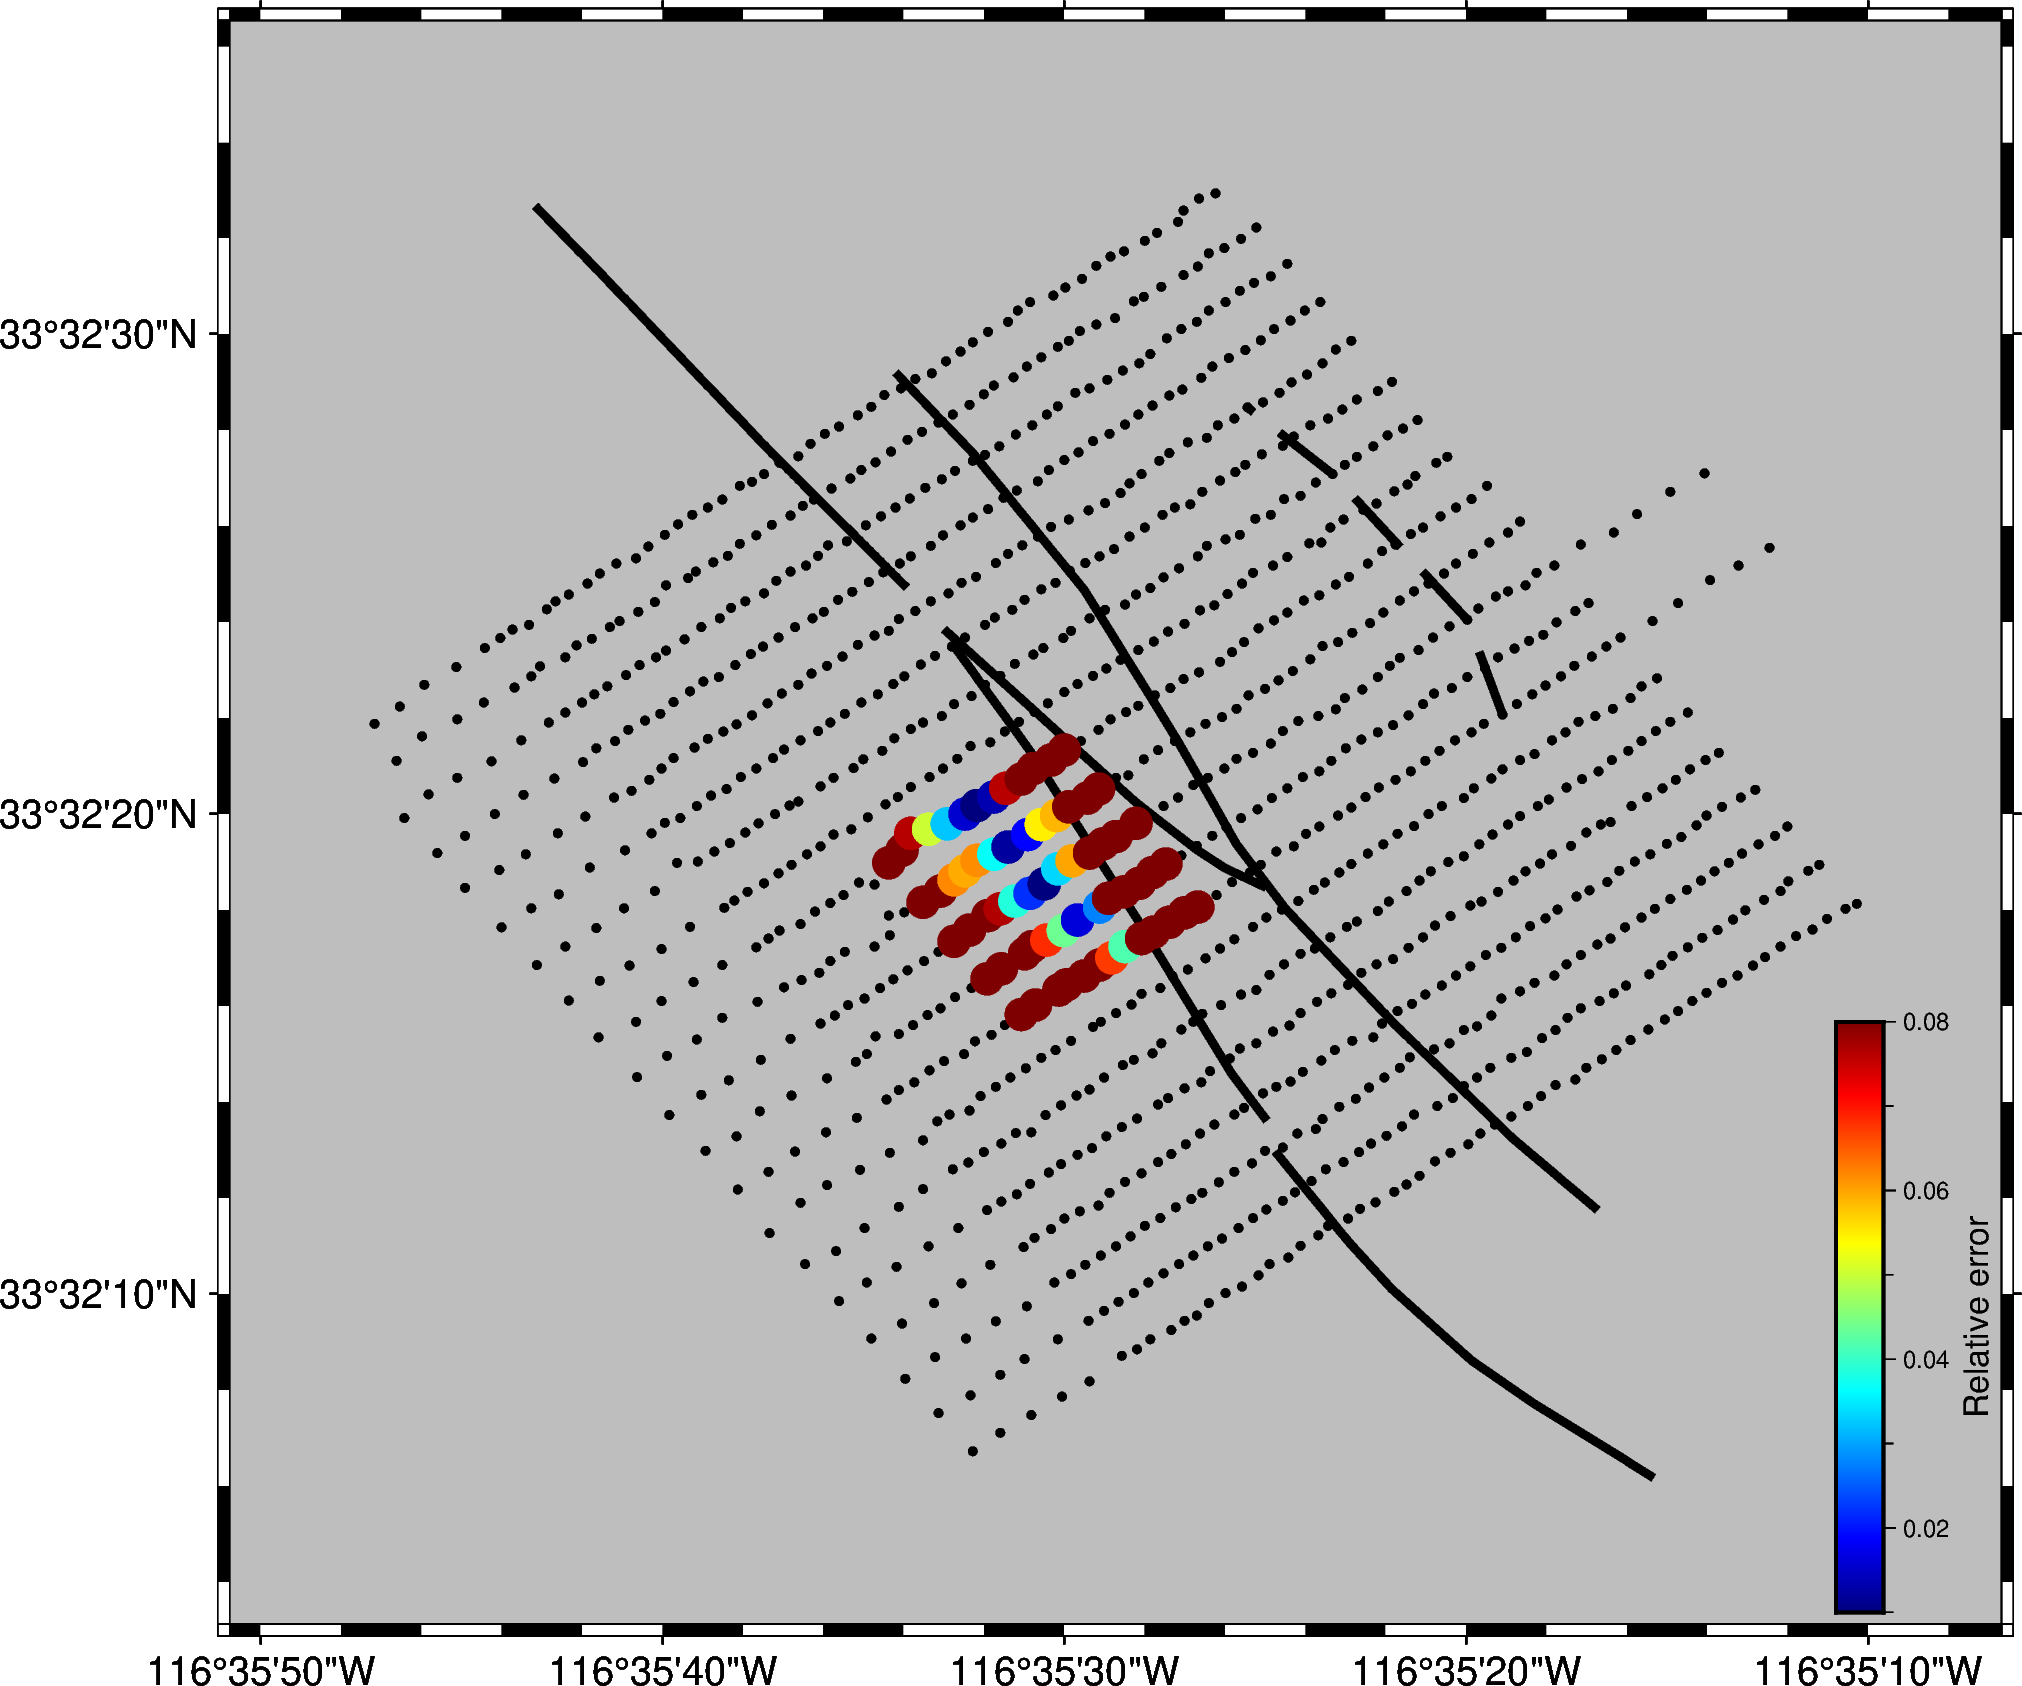

In [18]:
fig = pygmt.Figure()
flag_red = 0.001
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection="M15c", 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection="M15c", frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.08')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "2p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "2p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "2p,black,-")
# sample target and probe
flag_min = 0.01
flag_max = 0.08
err_norm = []
for i in range(len(err)):
    if err[i] < flag_min:
        err_norm.append(flag_min)
    elif err[i] > flag_max:
        err_norm.append(flag_max)
    else:
        err_norm.append(err[i])
pygmt.makecpt(cmap='jet', series=[flag_min, flag_max])
# colorbar内嵌到图片右下角
fig.colorbar(frame='af+l"Relative error"', position='jRB+o1c/0.1c+w5c/0.4c')
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.28',fill=err_norm,cmap = True)
fig.show()
fig.savefig(dir_image+'partitionworkflow_errorDistribution.eps')

### New partition comparison

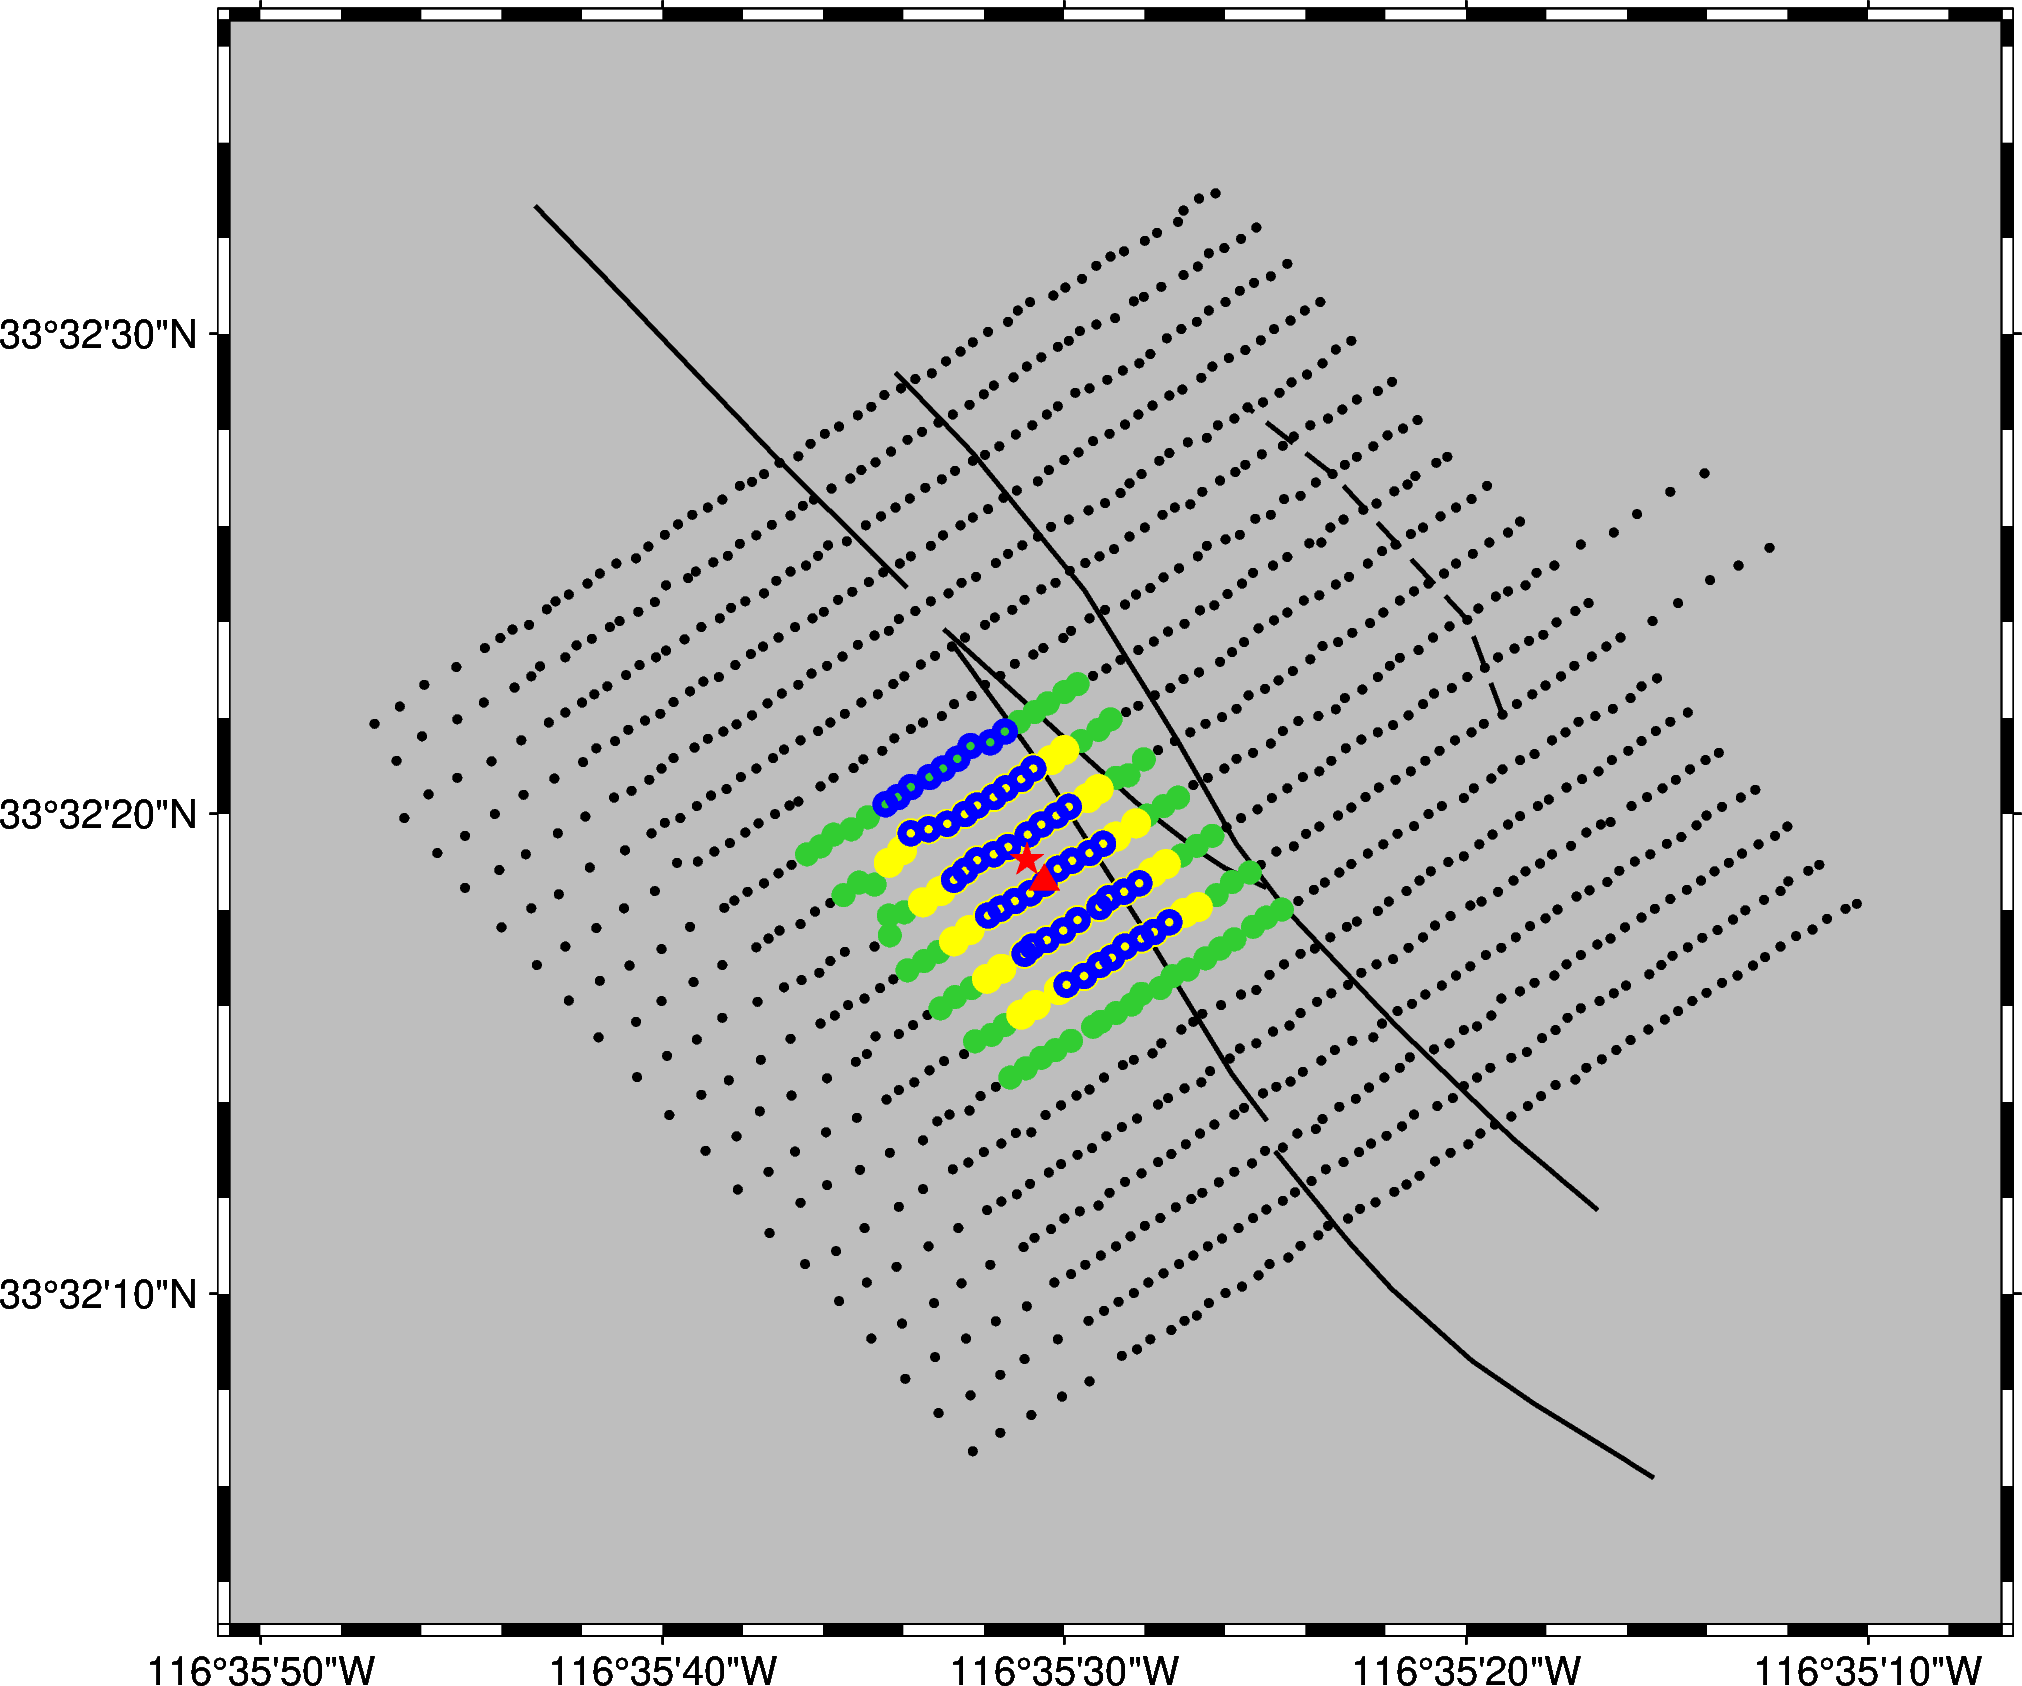

In [19]:
fig = pygmt.Figure()
flag_red = 0.001
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection="M15c", 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection="M15c", frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.08')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.2',fill='limegreen')
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.25',fill = 'yellow')
fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.15',pen='2p,blue')
fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.3',fill = 'red')
fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
fig.show()
fig.savefig(dir_image+'partitionworkflow_newPartition.eps')

### Workflow of FJ

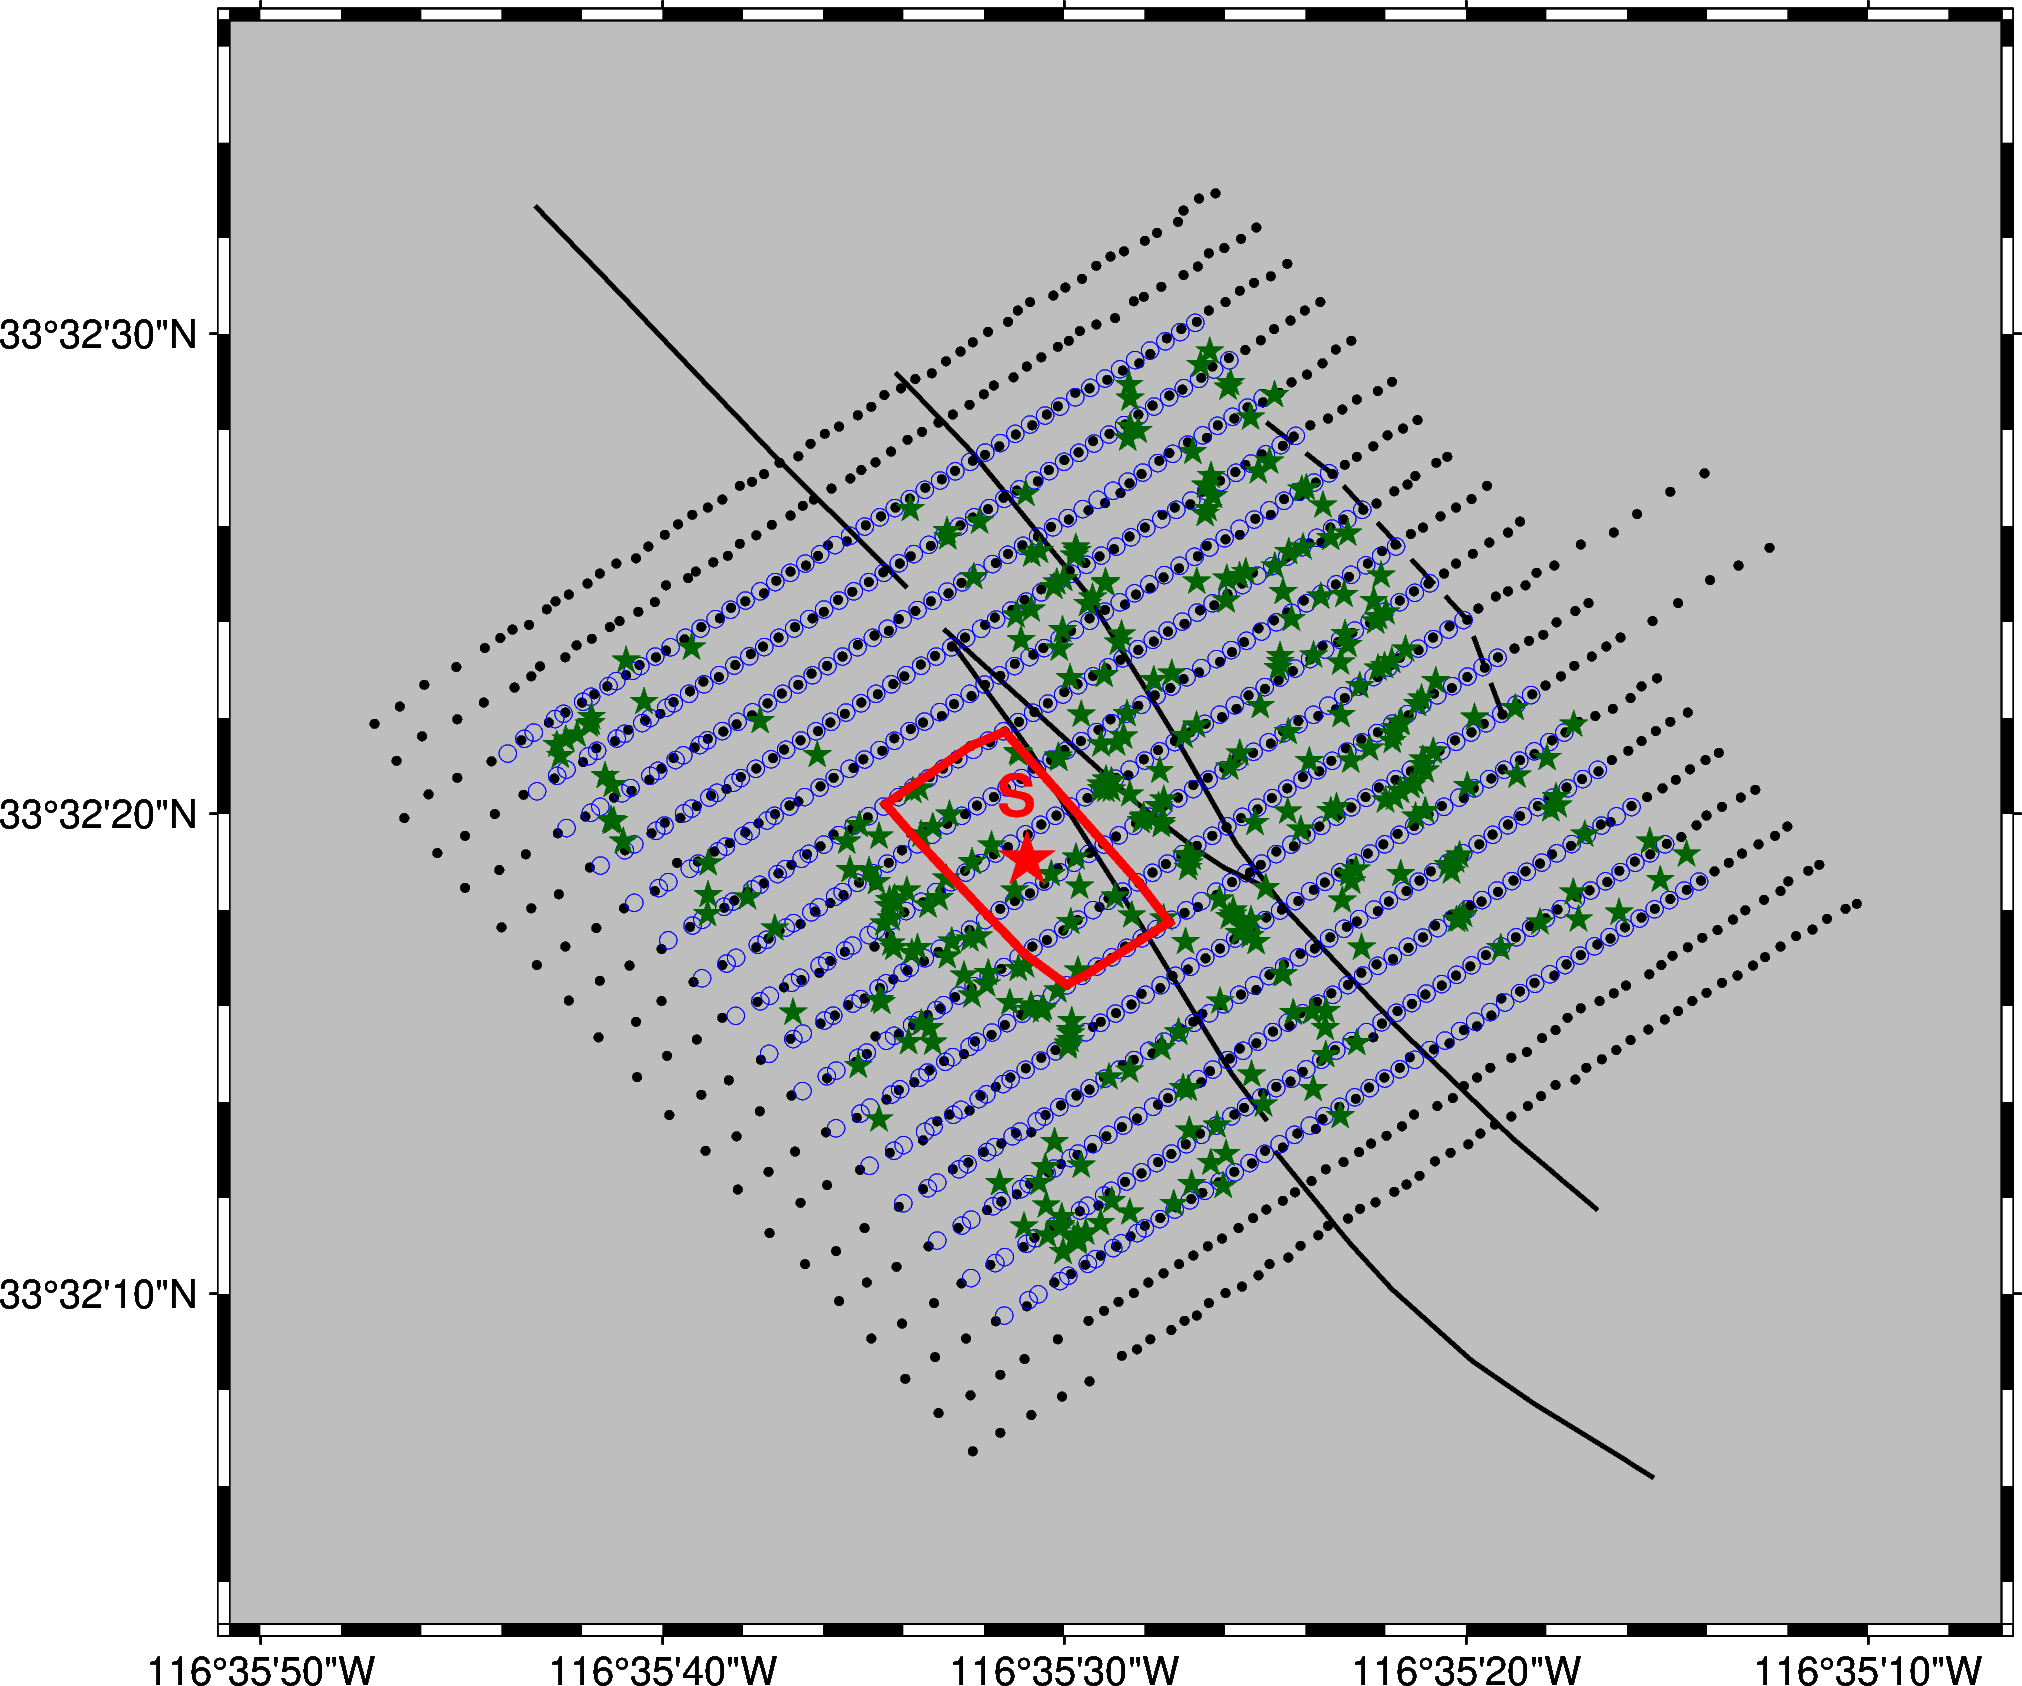

In [20]:
fig = pygmt.Figure()
flag_red = 0.001
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection="M15c", 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection="M15c", frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.08')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1p,black,-")
# All partitions
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.15',pen='0.1p,blue')
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.25',fill='darkgreen')
# This partition
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.2',fill='yellow')
fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='2p,red', label='target boundary')
fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.5',fill = 'red')
fig.text(text='S', x = -116.5920, y= 33.5390, font="14p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'fjworkflow_partition.eps')

### Vs horizontal

In [30]:
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
inter_file = dir_inv + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [31]:
vs_fund = inter['vs_fund']
vs = inter['vs']
lon_inter_in = inter['lon']
lat_inter_in = inter['lat']
z = inter['depth']
dz = inter['dz']
N = inter['N']

In [29]:
struc = {}
struc_fund = {}
flag = 0
for key_subwork in info_basic['key_subworks']:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    file_model_fund = dir_model_fund + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    model_fund = np.loadtxt(file_model_fund)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    struc_fund[key_subwork] = {}
    struc_fund[key_subwork]['layer'] = model_fund[:, 0]
    struc_fund[key_subwork]['z'] = model_fund[:, 1]
    struc_fund[key_subwork]['rho'] = model_fund[:, 2]
    struc_fund[key_subwork]['vs'] = model_fund[:, 3]
    struc_fund[key_subwork]['vp'] = model_fund[:, 4]
    struc_fund[key_subwork]['std'] = model_fund[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, len(info_basic['key_subworks'])))

vs_horizon = {}
vs_horizon_fund = {}
for i in range(N):
    vs_horizon[i] = []
    vs_horizon_fund[i] = []
    for key_subwork in info_basic['key_subworks']:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])
        vs_horizon_fund[i].append(struc_fund[key_subwork]['vs'][i])

Read structure model: 264--12-10 (1/326)
Read structure model: 536--49-16 (2/326)
Read structure model: 63--47-04 (3/326)
Read structure model: 493--38-15 (4/326)
Read structure model: 338--46-11 (5/326)
Read structure model: 249--40-09 (6/326)
Read structure model: 210--45-08 (7/326)
Read structure model: 41--10-04 (8/326)
Read structure model: 540--07-17 (9/326)
Read structure model: 184--18-08 (10/326)
Read structure model: 411--30-13 (11/326)
Read structure model: 201--36-08 (12/326)
Read structure model: 406--25-13 (13/326)
Read structure model: 324--32-11 (14/326)
Read structure model: 15--23-03 (15/326)
Read structure model: 572--09-18 (16/326)
Read structure model: 307--08-11 (17/326)
Read structure model: 476--08-15 (18/326)
Read structure model: 55--31-04 (19/326)
Read structure model: 113--25-06 (20/326)
Read structure model: 175--51-07 (21/326)
Read structure model: 169--45-07 (22/326)
Read structure model: 385--49-12 (23/326)
Read structure model: 9--16-03 (24/326)
Read st

In [36]:
fig = pygmt.Figure()
flag_red = 0.001
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection="M15c", 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection="M15c", frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.08')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1p,black,-")
# vs tomography
pygmt.makecpt(cmap='jet', series=[0.7, 0.95])
fig.colorbar(frame='af+l"Relative error"', position='jRB+o1c/0.1c+w5c/0.4c')
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.28',fill=err_norm,cmap = True)
fig.plot(x=lon_inter_in, y=lat_inter_in, style='c0.1',fill=vs[0], cmap=True)
fig.show()
#fig.savefig(dir_image+'fjworkflow_vs-hori.eps')